In [1]:
import scipy.io as spio

from __future__ import division

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from os import path

from scipy.io import loadmat

from wyrm.types import Data

from wyrm import plot
#plot.beautify()
from wyrm.types import Data
from wyrm import processing as proc

import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import seaborn as sns

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV

In [3]:
import time
def MLP_test(X_train, Y_train, X_test, fcns, hsizes = (100,), verbose = True, valid = False):
    predictions = {}
    models_perf = {}
    for i, fcn in enumerate(fcns):
        classifier = MLPClassifier(activation = fcn, hidden_layer_sizes = hsizes)
        if valid:
            # For validation split training data into
            # 70% training and 30% validation
            nt = round(X_train.shape[0] * 0.7)
            X_valid = X_train[nt:,:]
            X_train = X_train[:nt,:]
            Y_valid = Y_train[nt:]
            Y_train = Y_train[:nt]
            
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()        
        t_diff = t_end - t_start
        pred = classifier.predict_proba(X_test)
        train_score = classifier.score(X_train, Y_train)
        acc = predict_character(pred[:,1], 100, TRUE_LABELS_A, verbose = verbose)
        if valid:
            val_score = classifier.score(X_valid, Y_valid)
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score, 
                            'Validation score': val_score, 'Accuracy [%]': acc*100}
        else: 
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score, 
                                'Accuracy [%]': acc*100}
        if verbose:
            print("trained {fn} in {f:.2f} s".format(fn = fcn,f = t_diff))

    return pred, models_perf

In [4]:
import time
def MLP_test2(X_train, y_train, fcns, hsizes = (100,), verbose = True, valid = False):
    predictions = {}
    models_perf = {}
    for i, fcn in enumerate(fcns):
        classifier = MLPClassifier(activation = fcn, hidden_layer_sizes = hsizes)
        if valid:
            # For validation split training data into
            # 70% training and 30% validation
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, train_size = 0.7)
            
        t_start = time.clock()
        classifier.fit(X_train, y_train)
        t_end = time.clock()        
        t_diff = t_end - t_start
        pred = classifier.predict_proba(X_test)
        train_score = classifier.score(X_train, y_train)
        #acc = predict_character(pred[:,1], 100, TRUE_LABELS_A, verbose = verbose)
        if valid:
            val_score = classifier.score(X_test, y_test)
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score, 
                            'Validation score': val_score}#, 'Accuracy [%]': acc*100}
        else: 
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score}#, 
                                #'Accuracy [%]': acc*100}
        if verbose:
            print("trained {fn} in {f:.2f} s".format(fn = fcn,f = t_diff))

    return pred, models_perf

In [5]:
TRAIN_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Train.mat'
TRAIN_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Train.mat'

TEST_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Test.mat'
TEST_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Test.mat'

TRUE_LABELS_A = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'
TRUE_LABELS_B = 'MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR'

MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

MARKER_DEF_TRAIN = {'target': ['target'], 'nontarget': ['nontarget']}
MARKER_DEF_TEST = {'flashing': ['flashing']}

SEG_IVAL = [0, 700]

In [6]:
def load_bci_data(filename):
    """Load the BCI Competition III Data Set 2.
    This method loads the data set and converts it into Wyrm's ``Data``
    format. Before you use it, you have to download the data set in
    Matlab format and unpack it. The directory with the extracted files
    must contain the ``Subject_*.mat``- and the ``eloc64.txt`` files.
    .. note::
        If you need the true labels of the test sets, you'll have to
        download them separately from
        http://bbci.de/competition/iii/results/index.html#labels
    Parameters
    ----------
    filename : str
        The path to the matlab file to load
    Returns
    -------
    cnt : continuous `Data` object
    Examples
    --------
    >>> dat = load_bcicomp3_ds2('/home/foo/data/Subject_A_Train.mat')
    """
    STIMULUS_CODE = {
        0 : "blankMatrix",
        # cols from left to right
        1 : "agmsy5",
        2 : "bhntz6",
        3 : "ciou17",
        4 : "djpv28",
        5 : "ekqw39",
        6 : "flrx4_",
        # rows from top to bottom
        7 : "abcdef",
        8 : "ghijkl",
        9 : "mnopqr",
        10: "stuvwx",
        11: "yz1234",
        12: "56789_"
        }

    # load the matlab data
    data_mat = loadmat(filename)
    # load the channel names (the same for all datasets
    eloc_file = path.sep.join([path.dirname(filename), 'eloc64.txt'])
    with open(eloc_file) as fh:
        data = fh.read()
    channels = []
    for line in data.splitlines():
        if line:
            chan = line.split()[-1]
            chan = chan.replace('.', '')
            channels.append(chan)
    # fix the channel names, some letters have the wrong capitalization
    for i, s in enumerate(channels):
        s2 = s.upper()
        s2 = s2.replace('Z', 'z')
        s2 = s2.replace('FP', 'Fp')
        channels[i] = s2
    # The signal is recorded with 64 channels, bandpass filtered
    # 0.1-60Hz and digitized at 240Hz. The format is Character Epoch x
    # Samples x Channels
    data = data_mat['Signal']
    data = data.astype('double')
    # For each sample: 1 if a row/colum was flashed, 0 otherwise
    flashing = data_mat['Flashing'].reshape(-1)
    #flashing = np.flatnonzero((np.diff(a) == 1)) + 1
    ##Creates an array where only the initial intensifications of each series appear
    tmp = []
    for i, _ in enumerate(flashing):
        if i == 0:
            tmp.append(flashing[i])
            continue
        if flashing[i] == flashing[i-1] == 1:
            tmp.append(0)
            continue
        tmp.append(flashing[i])
    flashing = np.array(tmp)
    # For each sample: 0 when no row/colum was intensified,
    # 1..6 for intensified columns, 7..12 for intensified rows
    stimulus_code = data_mat['StimulusCode'].reshape(-1)
    stimulus_code = stimulus_code[flashing == 1]
    # 0 if no row/col was intensified or the intensified did not contain
    # the target character, 1 otherwise
    stimulus_type = data_mat.get('StimulusType', np.array([])).reshape(-1)
    # The target characters
    target_chars = data_mat.get('TargetChar', np.array([])).reshape(-1)
    fs = 240
    data = data.reshape(-1, 64)
    timeaxis = np.linspace(0, data.shape[0] / fs * 1000, data.shape[0], endpoint=False)
    dat = Data(data=data, axes=[timeaxis, channels], names=['time', 'channel'], units=['ms', '#'])
    dat.fs = fs
    # preparing the markers
    target_mask = np.logical_and((flashing == 1), (stimulus_type == 1)) if len(stimulus_type) > 0 else []
    nontarget_mask = np.logical_and((flashing == 1), (stimulus_type == 0)) if len(stimulus_type) > 0 else []
    flashing = (flashing == 1)
    flashing = [[i, 'flashing'] for i in timeaxis[flashing]]
    targets = [[i, 'target'] for i in timeaxis[target_mask]]
    nontargets = [[i, 'nontarget'] for i in timeaxis[nontarget_mask]]
    dat.stimulus_code = stimulus_code[:]
    stim = []
    for i,_ in enumerate(flashing):
        stim.append([flashing[i][0], STIMULUS_CODE[stimulus_code[i]]])
    stimulus_code = stim
    #stimulus_code = zip([t for t, _ in flashing], [STIMULUS_CODE[i] for i in stimulus_code])
    #Raises error "TypeError: '<' not supported between instances of 'tuple' and 'list'" when calling sort() 
    #stimulus_code =[[t for t,_ in flashing], [STIMULUS_CODE[i] for i in stimulus_code]]
    #print(type(stimulus_code), type(flashing), type(targets), type(nontargets))
    markers = flashing[:]
    markers.extend(targets)
    markers.extend(nontargets)
    markers.extend(stimulus_code)
    markers.sort()
    dat.markers = markers[:]
    return dat


In [7]:
def preprocessing_simple(dat, MRK_DEF, *args, **kwargs):
    """Simple preprocessing that reaches 97% accuracy.
    """
    fs_n = dat.fs / 2
    b, a = proc.signal.butter(5, [10 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
   
    dat = proc.subsample(dat, 20)
    epo = proc.segment_dat(dat, MRK_DEF, SEG_IVAL)
    fv = proc.create_feature_vectors(epo)
    return fv, epo

In [8]:
dat_train = load_bci_data(TRAIN_A)
dat_test = load_bci_data(TEST_A)

In [9]:
fv_train, epo_train = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

In [10]:
x = fv_train.data #traininig samples
y = fv_train.axes[0] #class labels

In [11]:
x_test = fv_test.data #traininig samples
y_test = fv_test.axes[0] #class labels

In [12]:
# scaler = StandardScaler()
# X = scaler.fit_transform(x)
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, train_size = 0.7)


In [13]:
# Subject B
dat_train_B = load_bci_data(TRAIN_B)
fv_train_B, epo_train = preprocessing_simple(dat_train_B, MARKER_DEF_TRAIN, SEG_IVAL)
x_B = normalize(fv_train.data) #traininig samples
y_B = fv_train.axes[0] #class labels
X_train_B, X_valid_B, y_train_B, y_valid_B = train_test_split(x_B, y_B, test_size = 0.3, train_size = 0.7)

## Optimization Algorithm

## SDG vs Adam

First, a search was conducted in order to assess the convenience of using one of either optimization algorithms for the backpropagation.

In [79]:
import time
results = {'sgd': {}, 'adam': {}}
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
for sv in ['sgd', 'adam']:
    auc = []
    times = []
    for act in activation_fcn:
        print('\nSolving for {} activation function...'.format((act)))
        cf = MLPClassifier(solver = 'sgd', activation = act)
        t_start = time.clock()
        res = cross_val_score(cf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)
        t_end = time.clock()
        auc.append(res)
        times.append(t_end - t_start)
    r = results[sv]
#     r['pred_proba'] = pred_proba
#     r['pred_classes'] = pred_classes
    r['auc'] = auc
    r['times'] = times


Solving for relu activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   41.3s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   51.1s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished



Solving for tanh activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.2min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished



Solving for logistic activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.7min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.4min finished



Solving for identity activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   20.4s remaining:   47.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   27.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.9s finished



Solving for relu activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   37.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   49.4s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.1s finished



Solving for tanh activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.0min remaining:   51.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished



Solving for logistic activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.7min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.6min finished



Solving for identity activation function...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   21.8s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   30.2s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.7s finished


In [33]:
results['sgd']['auc']

[array([ 0.64464415,  0.66792029,  0.64401833,  0.66999501,  0.64281315,
         0.66227403,  0.67768534,  0.66129624,  0.65386148,  0.64680043]),
 array([ 0.64146955,  0.6807413 ,  0.68220354,  0.66627318,  0.65528219,
         0.64383246,  0.66846406,  0.65388718,  0.66815164,  0.65043477]),
 array([ 0.72326477,  0.74772039,  0.74417404,  0.74532979,  0.70916146,
         0.7294894 ,  0.74442517,  0.75190244,  0.72301958,  0.73295467]),
 array([ 0.69253509,  0.68177446,  0.66681101,  0.66147123,  0.68866644,
         0.68955129,  0.6638905 ,  0.61494861,  0.67431399,  0.6890273 ])]

In [30]:
methods = []
for act in activation_fcn:
    methods.extend([act]*10)
    

In [85]:
sgd_auc = np.array(results['sgd']['auc']).reshape(-1)
sgd_mean_auc = np.array(results['sgd']['auc']).mean(axis = 0)
adam_auc = np.array(results['adam']['auc']).reshape(-1)
adam_mean_auc = np.array(results['adam']['auc']).mean(axis = 0)

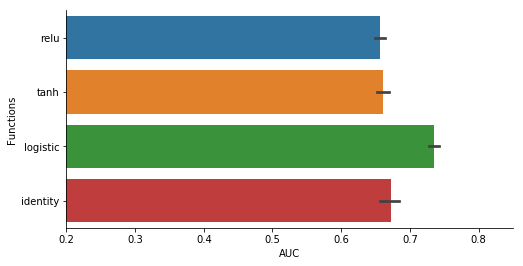

In [53]:
res = pd.DataFrame(data=sgd_auc, columns=['AUC'])
res['Functions'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=res, x='AUC', y = 'Functions')
plt.xlim(0.2, 0.85)
sns.despine()

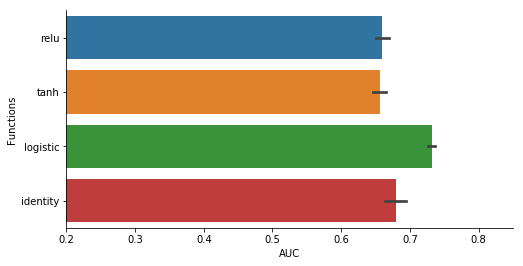

In [59]:
res = pd.DataFrame(data=adam_auc, columns=['AUC'])
res['Functions'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=res, x='AUC', y = 'Functions')
plt.xlim(0.2, 0.85)
sns.despine()

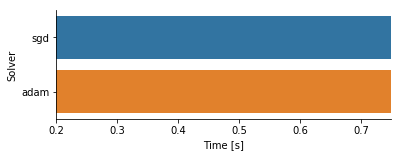

In [97]:
sgd_mean_time = np.array(results['sgd']['times']).mean(axis = 0)
adam_mean_time = np.array(results['adam']['times']).mean(axis = 0)
mean = []
solv = []
mean.append(sgd_mean_time)
solv.extend(['sgd'])
mean.append(adam_mean_time)
solv.extend(['adam'])
res = pd.DataFrame(data=mean, columns=['Time [s]'])
res['Solver'] = solv

plt.figure(figsize=[6,2])
sns.barplot(data=res, x='Time [s]', y = 'Solver')
plt.xlim(0.2, 0.75)
sns.despine()

### Adam
As both solvers showed the same performances for the given problem, and because Adam is recommended in (cite papers), we chose to train our model with this algorithm. As a consequence, we will tune its hyperparameters by carrying out a randomized search, rather than a gridsearch, due to the many parameters there are to tune. Their values where chosen according to the recommended values.

In [99]:
activation_fcn = ['relu', 'tanh', 'logistic', 'identity']
param = {'learning_rate_init': [0.001, 0.005, 0.01], 'beta_1': [0.85, 0.9, 0.95],
         'beta_2': [0.998, 0.999, 0.9999], 'epsilon': [1e-5, 1e-8, 1e-9]}


4087.0034338162636

In [109]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
results_adam = {}
auc = []
times = []
for act in activation_fcn:
    print('\nSolving for {} activation function...'.format((act)))
    cf = MLPClassifier(solver = 'adam', activation = act)
    t_start = time.clock()
    random_search = RandomizedSearchCV(cf, param_distributions = param,
                                       scoring='roc_auc', n_iter = 40, cv=cv, n_jobs=-1, verbose = 3)
    random_search.fit(X_train, y_train)
    t_diff = time.clock() - t_start
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((t_diff), 40))
    times.append(t_diff)
    auc.append(random_search.cv_results_)
    
    
results_adam['auc'] = auc
results_adam['times'] = times



Solving for relu activation function...
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 18.9min finished


RandomizedSearchCV took 1137.13 seconds for 40 candidates parameter settings.

Solving for tanh activation function...
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 30.6min finished


RandomizedSearchCV took 1847.44 seconds for 40 candidates parameter settings.

Solving for logistic activation function...
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 42.6min finished


RandomizedSearchCV took 2574.00 seconds for 40 candidates parameter settings.

Solving for identity activation function...
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 15.2min finished


RandomizedSearchCV took 916.96 seconds for 40 candidates parameter settings.


In [111]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [116]:
auc

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\util

[{'mean_fit_time': array([ 17.10975869,  23.11913977,  24.07061675,  22.83943408,
          29.00671391,  23.92672489,  25.01187396,  23.52894075,
          24.04148984,  26.26487846,  22.5828825 ,  18.26241584,
          26.95681112,  25.70982852,  21.4794256 ,  20.73571217,
          18.48261604,  25.25040598,  16.61567571,  23.25939808,
          23.64281712,  19.49780135,  19.37485802,  20.22460377,
          18.49577258,  27.91903529,  18.92074027,  23.22186542,
          25.20651422,  21.47584944,  23.20809412,  22.30160294,
          26.54822435,  17.02544401,  25.26192598,  16.32846484,
          24.13998001,  21.07554133,  22.07082305,  19.564484  ]),
  'std_fit_time': array([ 4.26664372,  5.9527357 ,  5.54119813,  4.990117  ,  6.33596607,
          6.90650706,  5.83190071,  7.18704079,  5.75084518,  9.36287508,
          4.31967998,  4.52647894,  5.5072743 ,  5.50880782,  3.15419035,
          3.56583567,  5.71637173,  8.59527099,  3.29237017,  3.65877068,
          2.4877861

In [113]:
report(results_adam['auc'])

TypeError: list indices must be integers or slices, not str

### Grid search for Learning rate

In [17]:
param = {'learning_rate_init': [0.001, 0.005, 0.01, 0.05]}
scores = []
grid = []
for act in activation_fcn:
    gs = GridSearchCV(MLPClassifier(solver = 'sgd', learning_rate = 'adaptive'), param, 
                      scoring = 'roc_auc', verbose = 4, cv = 3)
    gs.fit(X_train, y_train)
    scores.append(gs.grid_scores_)
    grid.append(gs)
    print("The best parameters are %s with a score of %0.2f"
      % (gs.best_params_, gs.best_score_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.648216 -  30.8s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.8s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.649382 -  21.4s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.3s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.644233 -  19.9s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.647445 -  39.1s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.677634 -  26.5s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.644465 -  22.4s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.554063 -  50.8s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.600903 -  23.0s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.583189 -  33.1s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.536418 -   4.6s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.505220 -   4.2s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.548874 -   4.4s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  4.7min finished


The best parameters are {'learning_rate_init': 0.005} with a score of 0.66
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.656827 -  15.4s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.646842 -  10.8s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.639765 -  14.7s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.0s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.637435 -  26.1s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.644305 -  10.5s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.644311 -  16.4s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.561152 -  28.3s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.656926 -  28.3s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.628038 -  19.6s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.527197 -   3.5s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.519553 -   3.6s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.506300 -   3.6s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.0min finished


The best parameters are {'learning_rate_init': 0.001} with a score of 0.65
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.626955 -  15.3s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.656206 -  10.7s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.659457 -  12.6s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.9s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.638420 -  29.2s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.649423 -  22.7s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.649166 -  16.1s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.576805 -  37.3s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.623875 -  35.0s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.604633 -  33.3s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.509648 -   4.1s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.536645 -   4.5s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.549362 -   4.2s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.8min finished


The best parameters are {'learning_rate_init': 0.001} with a score of 0.65
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.637633 -  18.7s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.7s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.654155 -  36.0s
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.643825 -  19.0s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.637594 -  30.2s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.649527 -  20.8s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.654888 -  16.8s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.582404 -  31.8s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.629116 -  27.5s
[CV] learning_rate_init=0.01 .........................................


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ learning_rate_init=0.01, score=0.610153 -  33.8s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.528670 -   4.0s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.552710 -   3.9s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.523597 -   4.2s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  4.1min finished


The best parameters are {'learning_rate_init': 0.005} with a score of 0.65


In [18]:
for i,act in enumerate(activation_fcn):
    print('\nActivation function ', act.upper())
    print(grid[i].best_params_, grid[i].best_score_)


Activation function  RELU
{'learning_rate_init': 0.005} 0.6565153017969664

Activation function  TANH
{'learning_rate_init': 0.001} 0.6478133293573709

Activation function  LOGISTIC
{'learning_rate_init': 0.001} 0.6475363589895197

Activation function  IDENTITY
{'learning_rate_init': 0.005} 0.6473345723607854


In [129]:
param = {'learning_rate_init': [0.001, 0.005, 0.01, 0.05]}
scores_adam = []
grid_adam = []
for act in activation_fcn:
    gs = GridSearchCV(MLPClassifier(solver = 'adam', learning_rate = 'adaptive'), param, scoring = 'roc_auc', verbose = 4, cv = 3)
    gs.fit(X_train, y_train)
    scores_adam.append(gs.grid_scores_)
    grid_adam.append(gs)
    print("The best parameters are %s with a score of %0.2f"
      % (gs.best_params_, gs.best_score_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.281356 -   2.4s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.341256 -   1.9s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.288625 -   3.0s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.227119 -   2.9s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.322581 -   3.9s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.210526 -   2.9s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.261017 -   2.6s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.310696 -   1.8s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.402377 -   3.5s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.040678 -   1.6s
[CV] learning_rate_init=0.05 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   31.6s finished


The best parameters are {'learning_rate_init': 0.01} with a score of 0.32
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.406780 -   2.8s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.234295 -   2.3s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.251273 -   2.3s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.330508 -   2.6s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.371817 -   4.0s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.310696 -   2.2s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.144068 -   2.6s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.162988 -   1.9s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.256367 -   2.7s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.032203 -   2.2s
[CV] learning_rate_init=0.05 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   31.1s finished


The best parameters are {'learning_rate_init': 0.005} with a score of 0.34
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.398305 -   3.2s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.368421 -   2.1s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.407470 -   3.1s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.147458 -   2.0s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.171477 -   3.4s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.164686 -   3.6s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.118644 -   3.0s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.154499 -   2.2s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.162988 -   2.9s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.027119 -   2.6s
[CV] learning_rate_init=0.05 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   34.9s finished


The best parameters are {'learning_rate_init': 0.001} with a score of 0.39
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.291525 -   2.9s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.348048 -   1.6s
[CV] learning_rate_init=0.001 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] ............... learning_rate_init=0.001, score=0.288625 -   2.3s
[CV] learning_rate_init=0.005 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV] ............... learning_rate_init=0.005, score=0.272881 -   3.3s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.237691 -   2.0s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.358234 -   1.7s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.281356 -   3.1s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.230900 -   2.7s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.091681 -   2.4s
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.293220 -   1.9s
[CV] learning_rate_init=0.05 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   28.2s finished


The best parameters are {'learning_rate_init': 0.001} with a score of 0.31


In [130]:
for i,act in enumerate(activation_fcn):
    print('\nActivation function ', act.upper())
    print(grid[i].best_params_, grid[i].best_score_)


Activation function  RELU
{'learning_rate_init': 0.001} 0.33370882958422543

Activation function  TANH
{'learning_rate_init': 0.001} 0.3291863378253952

Activation function  LOGISTIC
{'learning_rate_init': 0.001} 0.32352072921290564

Activation function  IDENTITY
{'learning_rate_init': 0.001} 0.33086388179627985


In [205]:
import time
def train_clf(sv, X_train, y_train, X_valid):
    activation_fcn = ['relu', 'tanh', 'logistic', 'identity']
    times = []
    predictions = []
    pred_proba = []
    SV = {}
    # Solver algortihm
    for act in activation_fcn:
        clf = MLPClassifier(solver = sv)
        t_start = time.clock()
        clf.fit(X_train, y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        times.append(t_diff)
        print(t_diff)
        # Predict classes
        predictions.append(clf.predict(X_valid))
        # Predict probabilities
        pred_proba.append(clf.predict_proba(X_valid))

    SV['times'] = times
    SV['predictions'] = predictions
    SV['probabilities'] = pred_proba
    return SV


In [231]:
SGD = train_clf('sgd', X_train, y_train, X_valid)
Adam = train_clf('adam', X_train, y_train, X_valid)

8.147691962858516
10.59375679110235
8.606784335544944
7.595853144874127
5.615983829917241
6.80949122034508
6.359758199672797
5.628133010661259


In [119]:
def get_mean_results(pred_classes, predictions, y_valid):
    activation_fcn = ['relu', 'tanh', 'logistic', 'identity']    
    cm = []
    recall = []
    accuracy = []
  #  precision = []
 #   log_loss = []
   # fbeta = []
    results = {}
    for pred in pred_classes: 
        cm.append(metrics.confusion_matrix(y_valid, pred))
        recall.append(metrics.recall_score(y_valid, pred))
        accuracy.append(metrics.accuracy_score(y_valid, pred))
    #results['Activation function'] = activation_fcn
    #results['confusion_matrix'] = cm
    results['recall'] = np.mean(recall)
    results['accuracy'] = np.mean(accuracy)
#     results['recall'] = recall
#     results['accuracy'] = accuracy

    return cm, results
    

In [232]:
cm_sgd, SGD_results = get_mean_results(SGD['predictions'], SGD['probabilities'], y_valid)
SGD_results['times'] = np.mean(SGD['times'])
cm_adam, Adam_results = get_mean_results(Adam['predictions'], Adam['probabilities'], y_valid)
Adam_results['times'] = np.mean(Adam['times'])

In [233]:
res = {'Adam': {'Accuracy': Adam_results['accuracy'], 'Recall': Adam_results['recall'], 'Time [s]': Adam_results['times']},
      'SGD': {'Accuracy': SGD_results['accuracy'], 'Recall': SGD_results['recall'], 'Time [s]': SGD_results['times']}}

### Matriz de confusión

In [135]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation = 90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize = 13)
    plt.xlabel('Etiqueta predicha', fontsize = 13)


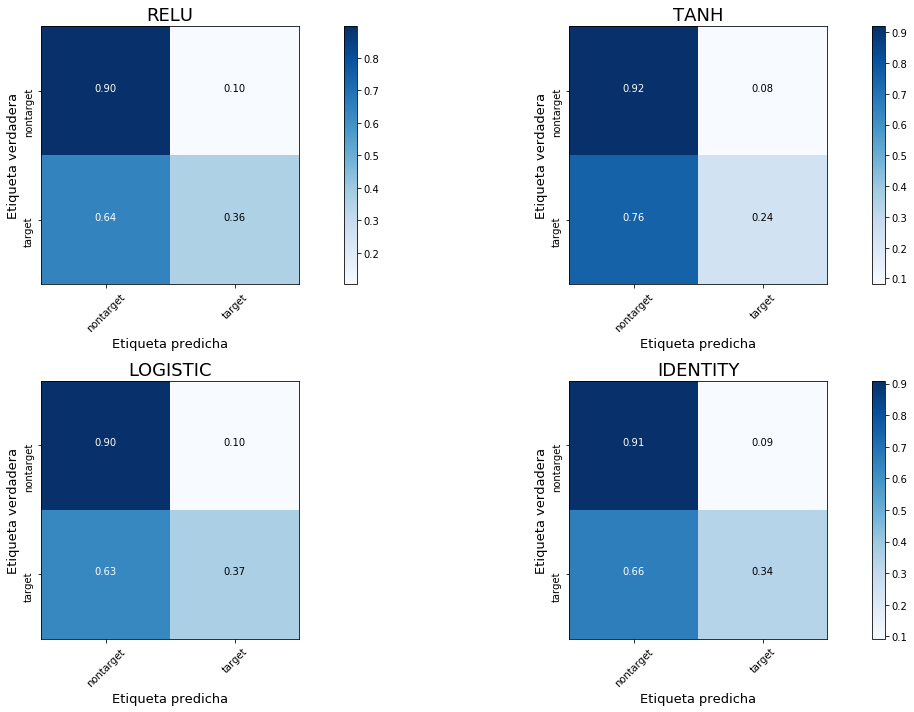

In [163]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    sb = '22'+str(i+1)
    plt.subplot(sb)
    plot_confusion_matrix(cm_adam[i], ['nontarget', 'target'],
                      title = activation_fcn[i], normalize = True) 
    plt.tight_layout()
    plt.show
 

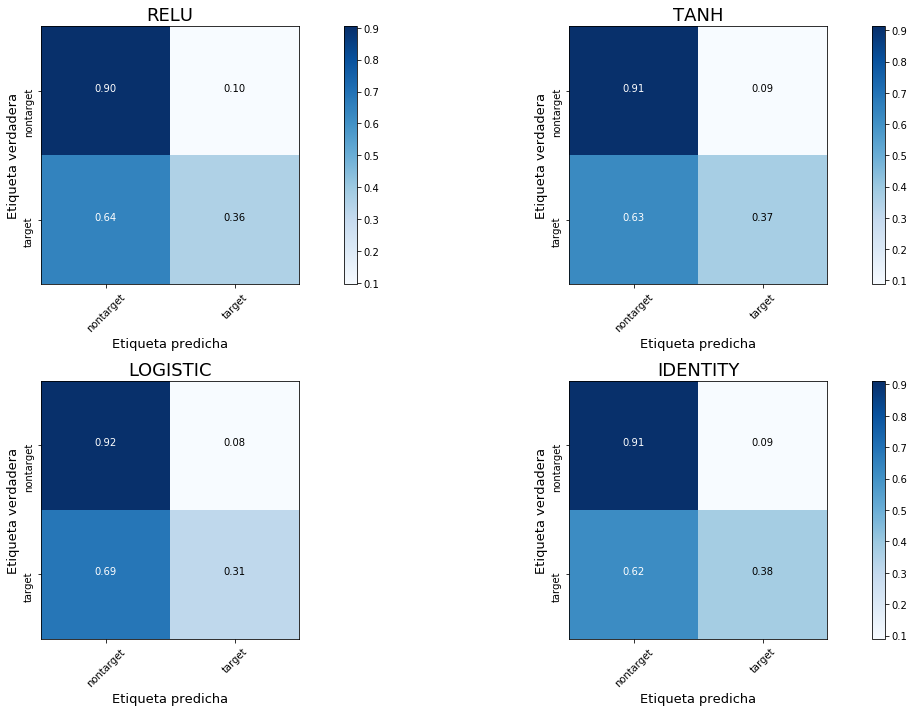

In [164]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    sb = '22'+str(i+1)
    plt.subplot(sb)
    plot_confusion_matrix(cm_sgd[i], ['nontarget', 'target'],
                      title = activation_fcn[i], normalize = True) 
    plt.tight_layout()
    plt.show
 

<function matplotlib.pyplot.show(*args, **kw)>

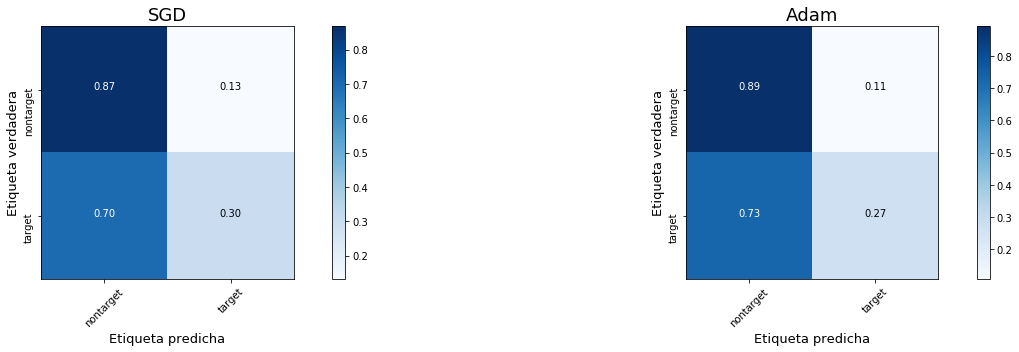

In [240]:
fig = plt.figure(figsize = (20, 5))
sb = '121'
plt.subplot(sb)
plot_confusion_matrix(cm_sgd_mean, ['nontarget', 'target'],
                  title = 'SGD', normalize = True) 
sb = '122'
plt.subplot(sb)

plot_confusion_matrix(cm_a_mean, ['nontarget', 'target'],
                  title = 'Adam', normalize = True) 
plt.tight_layout()
plt.show

# Grid search

In [24]:
param_grid = [
  {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                     #(10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['identity']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                    # (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['logistic']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes': [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                    # (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['tanh']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                     #(10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['relu']}]
 

In [20]:
activation_fcn = ['relu', 'tanh', 'logistic', 'identity']
param = {'learning_rate_init': [0.05, 0.01, 0.005, 0.001]}

In [33]:
scores = []
grid = []
for act in activation_fcn:
    gs = GridSearchCV(MLPClassifier(activation = act ), param, verbose = 4, cv = 3)
    gs.fit(X_train, y_train)
    scores.append(gs.grid_scores_)
    grid.append(gs)
    print("The best parameters are %s with a score of %0.2f"
      % (gs.best_params_, gs.best_score_))
    

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.784094 -   1.9s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.761625 -   1.9s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.778930 -   1.6s
[CV] learning_rate_init=0.01 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ................ learning_rate_init=0.01, score=0.816578 -   3.1s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.796919 -   4.1s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.779210 -   3.6s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.805937 -   4.5s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.784874 -   3.5s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.816755 -   2.8s
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.776813 -   4.4s
[CV] learning_rate_init=0.001 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   43.3s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.831700 -   1.5s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.828011 -   2.2s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.830485 -   2.3s
[CV] learning_rate_init=0.01 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s


[CV] ................ learning_rate_init=0.01, score=0.830580 -   5.0s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.818487 -   6.2s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.824321 -   2.7s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.820778 -   8.7s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.822409 -   4.3s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.823480 -   7.6s
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.800616 -   6.9s
[CV] learning_rate_init=0.001 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.831700 -   1.5s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.831933 -   2.0s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.829364 -   2.6s
[CV] learning_rate_init=0.01 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s


[CV] ................ learning_rate_init=0.01, score=0.826099 -   6.2s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.826331 -   4.9s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.806669 -   8.2s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.817138 -   6.7s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.815126 -  11.1s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.818156 -  12.7s
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.810697 -  16.4s
[CV] learning_rate_init=0.001 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.5min finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate_init=0.05 .........................................
[CV] ................ learning_rate_init=0.05, score=0.646878 -   3.3s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.770588 -   2.9s
[CV] learning_rate_init=0.05 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] ................ learning_rate_init=0.05, score=0.757075 -   3.5s
[CV] learning_rate_init=0.01 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s


[CV] ................ learning_rate_init=0.01, score=0.817978 -   2.9s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.822129 -   4.0s
[CV] learning_rate_init=0.01 .........................................
[CV] ................ learning_rate_init=0.01, score=0.821799 -   3.6s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.814058 -   2.7s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.819328 -   2.1s
[CV] learning_rate_init=0.005 ........................................
[CV] ............... learning_rate_init=0.005, score=0.820678 -   1.9s
[CV] learning_rate_init=0.001 ........................................
[CV] ............... learning_rate_init=0.001, score=0.781854 -   2.4s
[CV] learning_rate_init=0.001 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   41.3s finished


In [37]:
for gs in grid:
    print("The best parameters are %s with a score of %0.2f"
          % (gs.best_params_, gs.best_score_))

The best parameters are {'learning_rate_init': 0.005} with a score of 0.80
The best parameters are {'learning_rate_init': 0.05} with a score of 0.83
The best parameters are {'learning_rate_init': 0.05} with a score of 0.83
The best parameters are {'learning_rate_init': 0.01} with a score of 0.82


In [91]:
results = []
for i, activation in enumerate(activation_fcn):
    results.append(np.array([( f1m, f1s.std(), p['learning_rate_init']) 
            for p, f1m, f1s in grid[i].grid_scores_]))

C:\Users\sofis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('C:\\Users\\sofis\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


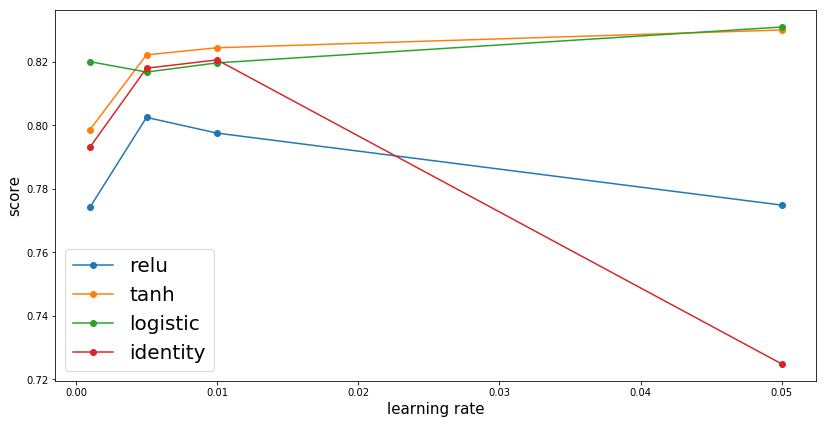

In [107]:
fig = plt.figure(figsize = (30,15))
for i, res in enumerate(results):
    #sp = '22'+str(i+1)
    plt.subplot(sp)
    plt.plot(res[:,2],res[:,0],'-o', label = activation_fcn[i])
    plt.legend(fontsize = 20)
    plt.xlabel('learning rate', fontsize = 15)
    plt.ylabel('score', fontsize = 15)
# plt.subplot(2,1,2)
# plt.plot(res[:,2],res[:,1],'-o')
plt.show()

In [96]:
for i, r in enumerate(results):
    print(r)

[[ 0.77488329  0.00960909  0.05      ]
 [ 0.79757236  0.0152624   0.01      ]
 [ 0.80252101  0.01323762  0.005     ]
 [ 0.77422969  0.00208439  0.001     ]]
[[ 0.83006536  0.0015348   0.05      ]
 [ 0.82446312  0.00493767  0.01      ]
 [ 0.82222222  0.00111073  0.005     ]
 [ 0.79869281  0.00414158  0.001     ]]
[[ 0.83099907  0.00115994  0.05      ]
 [ 0.81970121  0.0092147   0.01      ]
 [ 0.81680672  0.00125909  0.005     ]
 [ 0.8200747   0.00684521  0.001     ]]
[[ 0.7248366   0.05540793  0.05      ]
 [ 0.82063492  0.00188369  0.01      ]
 [ 0.81802054  0.0028563   0.005     ]
 [ 0.79318394  0.00827856  0.001     ]]


In [9]:
def predict_character(pred, n_characters, labels, verbose = True):
    pred_target = pred
    #unscramble_idx = fv_test.stimulus_code.reshape(100, 15, 12).argsort()
    unscramble_idx = fv_test.stimulus_code.reshape(n_characters, -1, 12).argsort()
    static_idx = np.indices(unscramble_idx.shape)
    #lda_out_prob = pred.reshape(100, 15, 12)
    lda_out_prob = pred.reshape(n_characters, -1, 12)
    lda_out_prob = lda_out_prob[static_idx[0], static_idx[1], unscramble_idx]

    # destil the result of the 15 runs
    lda_out_prob = lda_out_prob.sum(axis=1)
    lda_out_prob = lda_out_prob.argsort()


    cols = lda_out_prob[lda_out_prob <= 5].reshape(n_characters, -1)
    rows = lda_out_prob[lda_out_prob > 5].reshape(n_characters, -1)
    text = ''
    for i in range(n_characters):
        row = rows[i][-1]-6
        col = cols[i][-1]
        letter = MATRIX[row][col]
        text += letter
    a = np.array(list(text.upper()))
    b = np.array(list(labels))
    accuracy = np.count_nonzero(a == b) / len(a)
    if verbose:
        print()
        print('Constructed labels: %s' % text.upper())
        print('True labels       : %s' % labels)
        print('Accuracy: %.1f%%' % (accuracy * 100))
    return accuracy

#### Rectified linear unit function

In [12]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam')
clf.fit(x, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [13]:
pred = clf.predict_proba(x_test)
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WQWPL4COMRKO97YFZDEZ1CPF9NN2GR8DJCU24MEUO7OJAPTFYP7O6D7LDGYEGOK5VHNE6BUXOO1TEOLLUEE5HFGEEXAW_K4R2MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 78.0%


0.78

#### Sigma function

In [13]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='logistic', solver='adam')
clf.fit(x, y)
pred = clf.predict_proba(x_test)

In [14]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WP4PLHFIM_WO97YFZDEZ1DPC9NN2GR9DJCIVRMEUOOOJD2UFYP7O6K7LDAYEGOA5VHNE7BTXOO1TDOILUEE5HFSFEXAW_K1R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 81.0%


0.81

#### Hyperbolic tan function

In [15]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='tanh', solver='adam')
clf.fit(x, y)
pred = clf.predict_proba(x_test)

In [16]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WQWPLNC1MR3O97YFZ2DZ1DPO9NOVGRQDJCIJ4MEUOPOJARUFZPOO6V7FDAYEGOA5VBNELBCUOO1TDOLLUEE7HFA95XAWLK4R1MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 71.0%


0.71

#### Identity function

In [18]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='identity', solver='adam')
import time
t_start = time.clock()
clf.fit(normalize(x, axis = 1), y)
t_end = time.clock()
pred = clf.predict_proba(normalize(x_test, axis = 1))

print('time: {} seconds'.format(t_end - t_start))

time: 20.466706299315625 seconds


In [19]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VZNE6BTXOO1TDOILUEE5NFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 93.0%


0.93

In [16]:
list_fcns = ['identity', 'tanh', 'logistic', 'relu']

In [17]:
pred, models = MLP_test(x, y, x_test, list_fcns)


Constructed labels: WQWPLZCOMRWO97YFZDEZ1DPI9NNVGRWDJCUVRMEUOUOJD2UFYPOO6J7LDAYEGOG5VHNE6BWXOO1TDOILUEE5NFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 90.0%
trained identity in 16.92 s

Constructed labels: WQXPLZC1MRWO97YF4DEZ1DPF9QOVGRKCJCUJRMEUCUCJAPUFYP7O697LDAYF5OG5VHNE6BTXOO1TEOILUEE5BFB4DXAE_K2R3MLU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 72.0%
trained tanh in 22.81 s

Constructed labels: WQXPLBCIMREC57YBZDEZ1DPI9NNVGRQDJCIVRMEUOUOJD2UFYPOO6K7LDAYEGOA5VINECBUTOOZTDOILUEE5GFAFFXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 81.0%
trained logistic in 20.07 s

Constructed labels: WQXPLZC1MRKO97YLZ2EZ1DQF9NNVGRNDJUUJ4MEUOUOJBPUFYPOO6J7LDGYEGOG5VZNEHBTXOO1TDOILUEF5NFAEKXAW8K4RYMRU
True labels       : W

In [ ]:
import pandas as pd

In [74]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.850000,0.760000,0.790000,0.620000
time,7.158911,17.436235,25.894318,10.276268


### Normalized data

In [9]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns)

NameError: name 'x' is not defined

In [19]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
Accuracy [%],94.00000,94.000000,96.000000,81.000000
Time [s],19.45189,14.628866,47.387315,83.837302
Train score,0.86268,0.861765,0.863922,0.996471


### Scaled data

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(x)
X_test = scaler.fit_transform(x_test)

In [22]:
pred, models = MLP_test(X, y, X_test, list_fcns)


Constructed labels: WQXPLZCIMRQO97YFZDEZ1DPL9NNVGRWDJCOV4MEUOOOJD2UFYPOO6J7LDAYEGOG5VHNE6BWXOO1TDOILUEE5BFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 89.0%
trained identity in 4.97 s

Constructed labels: WQXPLHCIM_ER97YFYDEZ1DQC9NNVGRPDJCUVRMEOOC7JBPUFYPOO8J7LDAYEAOA5VZNEHBTXOO1TDOILUEE7NFZFEX5WNKFR3MDU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 74.0%
trained tanh in 14.06 s

Constructed labels: WQXPLNCIMRWO57YBZDEZ1DPI9NN2GR8DJCOVRMEUOOOJD2UFYPOO6H7LDGYEGOB5VH6EHBTXOO1TDOHLUEE56FA3AXAE_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 84.0%
trained logistic in 33.73 s

Constructed labels: WPWPLZCIMREO57YFZDEZ1DPI9NN2GRPDJUO2RMEUO1OJA2UFYPON687LDYYEGOA5VHNEHBT_OO1BEOILUEE5BFAEEXAW_K4RYGLU
True labels       : WQ

In [23]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
Accuracy [%],89.000000,74.000000,84.000000,79.000000
Time [s],4.967004,14.056281,33.732830,12.848193
Train score,0.846144,0.990523,0.998301,0.956993


## GrirdSearch

In [24]:
param_grid = [
  {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                     #(10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['identity']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                    # (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['logistic']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes': [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                    # (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['tanh']},
      {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes' : [(10,), (50,), (100,), (500, ), (1000,)]#,
                                                                     #(10, 50), (10, 50, 100), (50, 100), (50, 100, 500)],
   'activation': ['relu']}]
 

In [25]:
from sklearn.grid_search import GridSearchCV
X = x_norm[:5000,:]
Y = y[:5000]
gs = GridSearchCV(MLPClassifier(), param_grid, verbose = 4, cv = 2)
gs.fit(X,Y)

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.05 
[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.05, score=0.835600 -   0.3s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.05 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.05, score=0.833600 -   0.4s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.01 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.01, score=0.830400 -   1.0s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.01 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.01, score=0.823200 -   0.9s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.005 
[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.828800 -   1.1s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.005 
[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.826400 -   1.4s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.829600 -   4.2s
[CV] activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.001 
[CV]  activation=identity, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.831600 -   3.1s
[CV] activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.825600 -   0.9s
[CV] activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.832400 -   0.4s
[CV] activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.829200 -   0.8s
[CV] activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=identity, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.839600 -   0.5s


[CV]  activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.01, score=0.829600 -   0.3s
[CV] activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005 
[CV]  activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005, score=0.822800 -   0.6s
[CV] activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005 
[CV]  activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005, score=0.832400 -   0.4s
[CV] activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001 
[CV]  activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001, score=0.832800 -   1.0s
[CV] activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001 
[CV]  activation=identity, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001, score=0.819600 -   1.7s
[CV] activation=identity, hidden_layer_sizes=(50, 100), learning_rate_init=0.05 
[CV]  activation=iden

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, score=0.816400 -   4.3s
[CV] activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, score=0.817200 -   3.3s
[CV] activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.005 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.824400 -   4.6s
[CV] activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.005 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.824400 -   5.0s
[CV] activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.832400 -   5.2s
[CV] activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.835600 -   4.6s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.816800 -   3.3s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.806400 -   2.0s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.01 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.810800 -   7.7s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.818400 -   5.3s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.005 
[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.005, score=0.830400 -   3.8s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.005 
[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.005, score=0.832800 -   3.9s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.001, score=0.832000 -   8.1s
[CV] activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(50,), learning_rate_init=0.001, score=0.834000 -   7.5s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.05, score=0.793200 -   3.7s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.05, score=0.790800 -   2.2s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.01, score=0.799600 -   5.3s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.01, score=0.829200 -   3.7s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.005 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.005, score=0.831200

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.001, score=0.832400 -  12.0s
[CV] activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.001 
[CV]  activation=logistic, hidden_layer_sizes=(100,), learning_rate_init=0.001, score=0.833200 -   9.5s
[CV] activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.05, score=0.790800 -  16.8s
[CV] activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.05, score=0.793600 -  12.7s
[CV] activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.01, score=0.834400 -   9.4s
[CV] activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(500,), learning_rate_init=0.01, score=0.83960

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.005, score=0.798400 -   6.1s
[CV] activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.005 
[CV]  activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.005, score=0.792000 -   5.2s
[CV] activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.001, score=0.824800 -   5.8s
[CV] activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(10, 50), learning_rate_init=0.001, score=0.830000 -   5.6s
[CV] activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.05, score=0.807200 -   1.8s
[CV] activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.05 
[CV]  activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.05, score=0.803200 -   1.8s
[CV] activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.01, score=0.832000 -   1.1s
[CV] activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.01 
[CV]  activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.01, score=0.811200 -   3.7s
[CV] activation=logistic, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005 
[CV]  activation=logistic, h

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.804800 -   4.3s
[CV] activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.005 
[CV]  activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.005, score=0.817600 -   0.7s
[CV] activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.830400 -   4.2s
[CV] activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.001 
[CV]  activation=tanh, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.831600 -   2.9s
[CV] activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.819600 -   2.0s
[CV] activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.795200 -   1.0s
[CV] activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.808800 -   4.7s
[CV] activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.832400 -   0.6s
[CV] activation=tanh, hidden_layer_sizes=(50

[CV]  activation=tanh, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.005, score=0.829600 -   1.1s
[CV] activation=tanh, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001 
[CV]  activation=tanh, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001, score=0.824400 -   1.9s
[CV] activation=tanh, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001 
[CV]  activation=tanh, hidden_layer_sizes=(10, 50, 100), learning_rate_init=0.001, score=0.823200 -   2.9s
[CV] activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.05 
[CV]  activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.05, score=0.806800 -   2.6s
[CV] activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.05 
[CV]  activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.05, score=0.788400 -   1.9s
[CV] activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.01 
[CV]  activation=tanh, hidden_layer_sizes=(50, 100), learning_rate_init=0.01, sc

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.817600 -   6.0s
[CV] activation=relu, hidden_layer_sizes=(10,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(10,), learning_rate_init=0.001, score=0.816800 -   6.2s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.808800 -   1.0s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.05, score=0.773600 -   1.1s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.805200 -   3.4s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, score=0.824400 -   1.9s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.005 
[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.005, score=0.800800 -   4.9s
[CV] activation=relu, hidden_layer_sizes=(50

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, score=0.802800 -  10.9s
[CV] activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001 


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, score=0.816800 -  10.4s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.05, score=0.755600 -   1.0s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.05, score=0.790800 -   1.1s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01, score=0.807600 -   3.9s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01, score=0.813600 -   2.4s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.005 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.005, score=0.808800 -   5.4s
[CV] activation=relu, hidden_layer

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.001, score=0.813600 -  16.3s
[CV] activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.001 
[CV]  activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.001, score=0.821200 -  12.6s
[CV] activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.05, score=0.802000 -   6.9s
[CV] activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.05 
[CV]  activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.05, score=0.794800 -   8.9s
[CV] activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.01, score=0.815200 -  15.1s
[CV] activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.01 
[CV]  activation=relu, hidden_layer_sizes=(500,), learning_rate_init=0.01, score=0.787200 -  12.1s
[CV] activation=relu, hidden_laye

[CV]  activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.005, score=0.781600 -   2.0s
[CV] activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.005 
[CV]  activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.005, score=0.784400 -   3.6s
[CV] activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.001 
[CV]  activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.001, score=0.802000 -   4.6s
[CV] activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.001 
[CV]  activation=relu, hidden_layer_sizes=(50, 100, 500), learning_rate_init=0.001, score=0.800400 -   3.4s


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 38.4min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes': [(10,), (50,), (100,), (500,), (1000,), (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)], 'activation': ['identity']}, {'learning_rate_init': [0.05, 0.01, 0.005, 0.001], 'hidden_layer_sizes': [(10,), (50,), (100,...00,), (500,), (1000,), (10, 50), (10, 50, 100), (50, 100), (50, 100, 500)], 'activation': ['relu']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=No

In [26]:

print("The best parameters are %s with a score of %0.2f"
      % (gs.best_params_, gs.best_score_))

The best parameters are {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate_init': 0.01} with a score of 0.84


In [43]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.
scores = gs.cv_results_['mean_test_score'].reshape(len(param_grid[0]['learning_rate_init']),
                                                     len(param_grid[0]['hidden_layer_sizes']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid[0]['learning_rate_init'])), param_grid[0]['learning_rate_init'], rotation=45)
plt.yticks(np.arange(len(param_grid[0]['hidden_layer_sizes'])), param_grid[0]['hidden_layer_sizes'])
plt.title('Validation accuracy')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### Hidden layers size

In [84]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (200,))


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained identity in 16.45 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEKBTXOO1TDOILUEE5HFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%
trained tanh in 20.22 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 52.40 s

Constructed labels: WWXPLZFIMREO97YFZDEZ1DPC9NN2GRQDJUOJ4MEUOUOJDPUFYPOO6K7LDAYEGOA5VHNEZBTXO1ZBDOILUEEAHF5FEXAWUK4R3MXU
True labels       : W

In [85]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.960000,0.940000,0.960000,0.76000
time,16.448045,20.220809,52.403316,92.07403


In [86]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (50,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained identity in 9.45 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 21.66 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 51.22 s

Constructed labels: WQXPLZCIM4ECW7YIZDEZ1DQL9NNVGR8DJUIVRMEUOUOJA2UFYPOO687LDGYEGOA5VHNEHATXOO1TDOILUEE5BFAFEXAE_KFR3MXU
True labels       : WQ

In [87]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.950000,0.950000,0.960000,0.810000
time,9.451202,21.663958,51.218713,64.421723


In [68]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)

In [88]:
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (20,))


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 97.0%
trained identity in 15.43 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 15.06 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 34.34 s

Constructed labels: WQXPLZELMREO57YFYDEZ1DPL9NNVGR8DHUUVRMEUOOOJJPUFYPOO6J7LDAYE5OA5VHBE6BTXOO1TDOILUEEAMFAEEXAW_K4R3MXU
True labels       : W

In [89]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (10,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 97.0%
trained identity in 19.51 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained tanh in 16.00 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 43.60 s

Constructed labels: WPYPLZDOMREO97YFZ2EZ1DPC9NN2GRPDHUIV_MEUOCOJDPUFYPOO9J7RDGYEGOG5VLNEHBTXOO1TEOHLUEEABF5FEXAW_K4R3MRU
True labels       : W

In [90]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.970000,0.960000,0.960000,0.770000
time,19.509023,16.000125,43.601013,86.100817


In [91]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (5,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5NFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%
trained identity in 12.43 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 17.66 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 37.09 s

Constructed labels: WPXPLZCIM4EO97YDZDEZ1DPC9NNVGR8DJC5VLMEUOUOJDPUFYPOO6J7LDAYEGOA5VHNEBBTXUO1TDOHLUEE5BFAEEXEW7K4R3MRU
True labels       : W

### Tomar una parte del training set para validar

Training set: tomo 70% para entrenar y 30% para validar.

In [228]:
x_train = fv_train.data
y_train = fv_train.axes[0]

In [230]:
pred, models = MLP_test(x, y, x_test, list_fcns, valid = True)


Constructed labels: W9X8LZOFMREA9OYFZDEZ1CP69NR2GRHDJCOJRMEUOUOJBPTFYP7QNE7RDGYESOH5VUTEBBU_UO1TDOILUEE5NFB9DXAE9K4R3MLU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 62.0%
trained identity in 3.43 s

Constructed labels: WQXVLZC1M4KC_7YLYDEZ1DPC9NQ8HRKDHUXJMMEUCOCJDPUFMP7O6K7LDAYEGOG5VTNEFAVXOO1TDOILUEEANFADAXFWLKYR3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 64.0%
trained tanh in 5.72 s

Constructed labels: WQXVLHCIM_WO97YDBDEZ1DPI9NNVG4QDJCOXRMEVOUCJD2UFYPOO9W7FDAYEGOG5VZNEHBH_OO1TDOILUEE5MF5DEXAWRK3R9MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 72.0%
trained logistic in 6.81 s

Constructed labels: WKX7L6L1N_ROW7YFWDEZ1BQH9MN3G4PVJUXHRPETUUOJN2U_YMIOJHIGDGYKGO65VVNEJFUUO13BFOZKUED5BF5_FXATOK4RYQR1
True labels       : WQXP

In [231]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
Accuracy [%],62.000000,64.000000,72.000000,45.000000
Time [s],3.434876,5.716495,6.814153,1.360296
Train score,0.827544,0.913966,0.969893,0.951279
Validation score,0.797603,0.802365,0.823477,0.774460


In [232]:
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns,(50,), valid = True)


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VZNEHBTXOO1TDOILUEE5NFAQEXAW7K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained identity in 8.66 s

Constructed labels: WQXPLZCIM_KO97YFYDEZ1DPI9NNVGRQDJCUVRMEUOUOJD2UFYPOO6J7LDAYEGOA5VZNEHBTXOO1TDOILUEE5NFAEEXAWOK4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 91.0%
trained tanh in 7.18 s


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Constructed labels: WQXPLZCIMRQO97YFZDEZ1DPI9NNVGRQDJCUJRMEUOOOJD2UFYPOO6H7LDGYEGOA5VZNEHBTXOO1TDOILUEE5NFAEEXAWOK4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 92.0%
trained logistic in 15.51 s

Constructed labels: WWXPLNCIM_NUS7YFYDEZ1DQ69NN2GRDDJC1HRMEU1UOJD2UFYP7O6H1LDAYEGOB5VZNEFBUIOO1TDOHRUEE5BF54DXAB7K4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 67.0%
trained relu in 11.48 s


## Comparación tamaños de capas ocultas

In [49]:
h_sizes = [10, 20, 50, 100, 200, 300]

In [74]:
model = []
for h in h_sizes:
    model.append(MLP_test2(x_norm, y, list_fcns,(h,), valid = True, verbose = False))
    
    

In [78]:
times_dict = {}
for fcn in list_fcns:
    t = []
    for i in range(len(h_sizes)):
        t.append(model[i][1][fcn]['Time [s]'])
    times_dict[fcn] = t
acc_dict = {}
# for fcn in list_fcns:
#     a = []
#     for i in range(len(h_sizes)):
#         a.append(model[i][1][fcn]['Accuracy [%]'])
#     acc_dict[fcn] = a

valscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model[i][1][fcn]['Validation score'])
    valscore_dict[fcn] = a

trainscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model[i][1][fcn]['Train score'])
    trainscore_dict[fcn] = a    
        

In [82]:
from matplotlib import legend

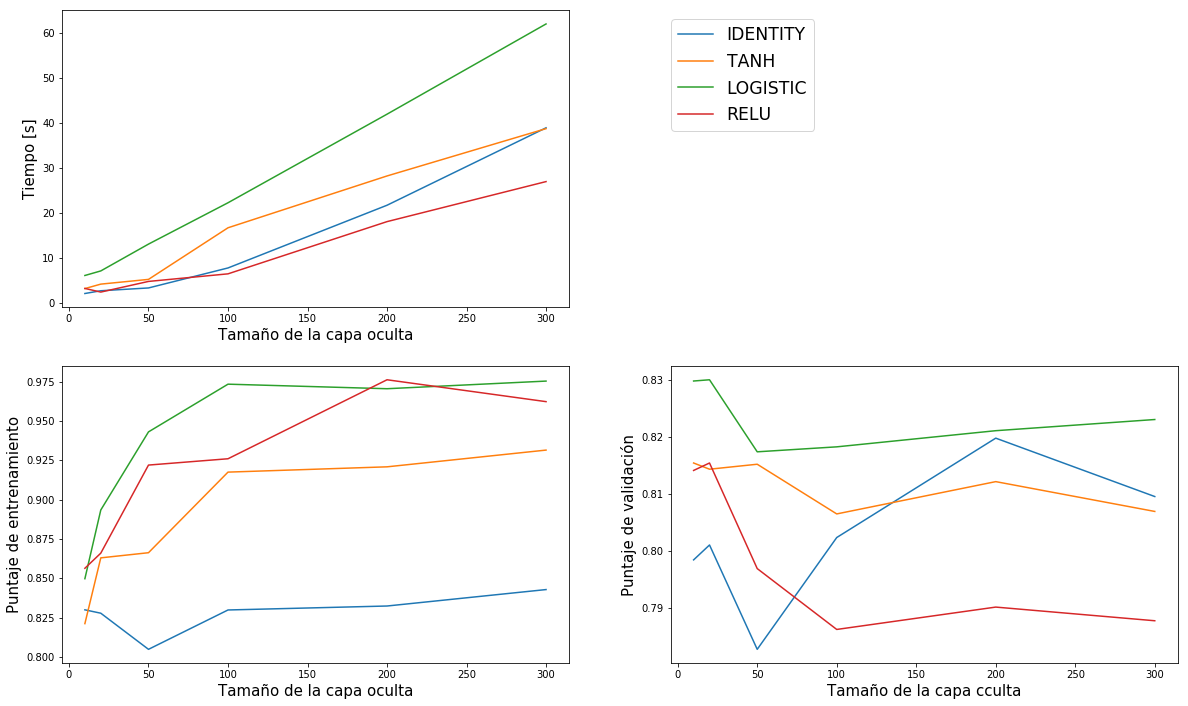

In [131]:
fig = plt.figure(figsize = (20,12))

plt.subplot(221)
plt.plot(h_sizes, times_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, times_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, times_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, times_dict[list_fcns[3]], label = list_fcns[3].upper())


plt.xlabel('Tamaño de la capa oculta', fontsize = 15)
plt.ylabel('Tiempo [s]', fontsize = 15)
#plt.title('Tiempo vs Tamaño de la capa oculta', fontsize = 20)
plt.legend(bbox_to_anchor=(1.5, 1), ncol=1, fontsize='xx-large')

# plt.xlabel('Hidden layer sizes', fontsize = 15)
# plt.ylabel('Time [s]', fontsize = 15)
# plt.title('Time vs hidden layer sizes', fontsize = 20)
# plt.legend(bbox_to_anchor=(1.5, 1), ncol=1, fontsize='xx-large')

# plt.subplot(222)
# plt.plot(h_sizes, acc_dict[list_fcns[0]], label = list_fcns[0].upper())
# plt.plot(h_sizes, acc_dict[list_fcns[1]], label = list_fcns[1].upper())
# plt.plot(h_sizes, acc_dict[list_fcns[2]], label = list_fcns[2].upper())
# plt.plot(h_sizes, acc_dict[list_fcns[3]], label = list_fcns[3].upper())
# plt.legend(fontsize='xx-large')
# plt.xlabel('Hidden layer sizes', fontsize = 15)
# plt.ylabel('Accuracy [%]', fontsize = 15)
# plt.title('Accuracy vs hidden layer sizes', fontsize = 20)

plt.subplot(223)
plt.plot(h_sizes, trainscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[3]], label = list_fcns[3].upper())
#plt.legend(fontsize='xx-large')

plt.xlabel('Tamaño de la capa oculta', fontsize = 15)
plt.ylabel('Puntaje de entrenamiento', fontsize = 15)
#plt.title('Puntaje de entrenamiento vs Tamaño de la capa oculta', fontsize = 20)
#plt.xlabel('Hidden layer sizes', fontsize = 15)
# plt.ylabel('Train score', fontsize = 15)
# plt.title('Train score vs hidden layer sizes', fontsize = 20)
plt.subplot(224)
plt.plot(h_sizes, valscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[3]], label = list_fcns[3].upper())
#plt.legend(fontsize='xx-large')

plt.xlabel('Tamaño de la capa cculta', fontsize = 15)
plt.ylabel('Puntaje de validación', fontsize = 15)
#plt.title('Puntaje de validación vs Puntaje de la capa oculta', fontsize = 20)

# plt.xlabel('Hidden layer sizes', fontsize = 15)
# plt.ylabel('Validation score', fontsize = 15)
# plt.title('Validation score vs hidden layer sizes', fontsize = 20)

#plt.tight_layout(h_pad=1.5)
plt.show()


In [237]:
h_sizes = [(5, 10),  (5, 10, 20), (10, 20, 30), (20, 50, 100)]
model2 = []
for h in h_sizes:
    model2.append(MLP_test(x_norm, y, x_test_norm, list_fcns, h, valid = True, verbose = False))

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [246]:
times_dict2 = {}
for fcn in list_fcns:
    t = []
    for i in range(len(h_sizes)):
        t.append(model2[i][1][fcn]['Time [s]'])
    times_dict2[fcn] = t
acc_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Accuracy [%]'])
    acc_dict2[fcn] = a

valscore_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Validation score'])
    valscore_dict2[fcn] = a

trainscore_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Train score'])
    trainscore_dict2[fcn] = a    
        

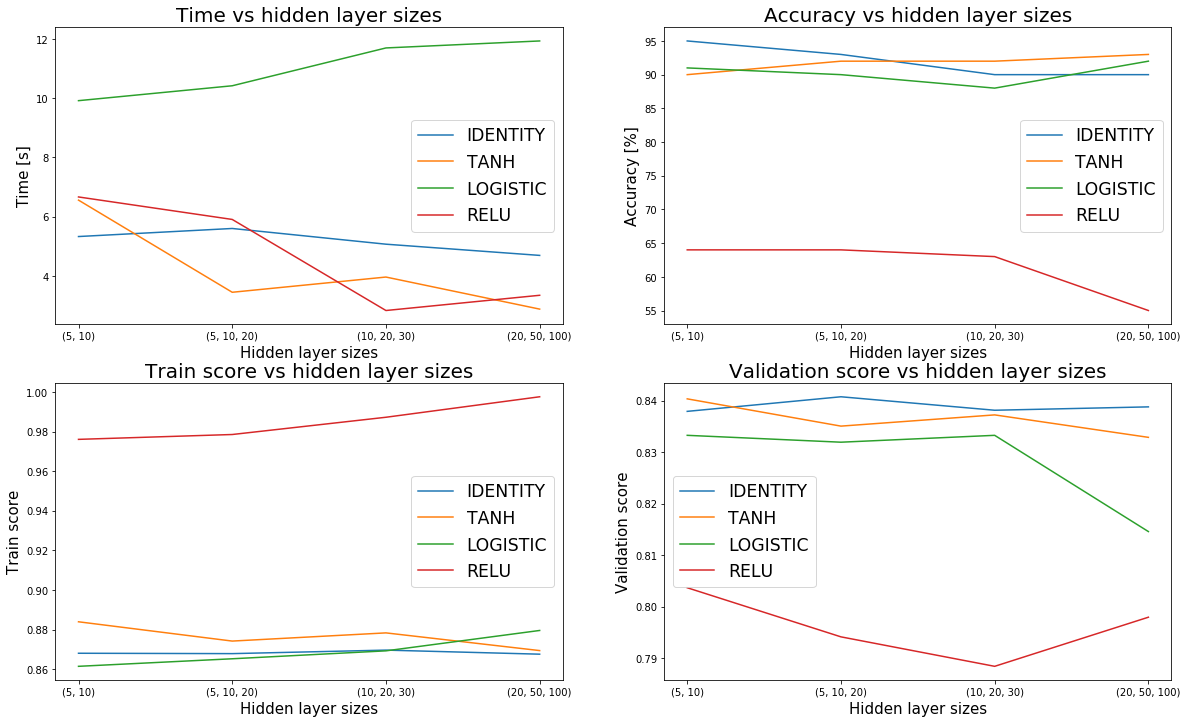

In [247]:
h = [str(h) for h in h_sizes]
fig = plt.figure(figsize = (20,12))

plt.subplot(221)
plt.plot(h, times_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, times_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, times_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, times_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Time [s]', fontsize = 15)
plt.title('Time vs hidden layer sizes', fontsize = 20)

plt.subplot(222)
plt.plot(h, acc_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, acc_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, acc_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, acc_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Accuracy [%]', fontsize = 15)
plt.title('Accuracy vs hidden layer sizes', fontsize = 20)

plt.subplot(223)
plt.plot(h, trainscore_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, trainscore_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, trainscore_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, trainscore_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Train score', fontsize = 15)
plt.title('Train score vs hidden layer sizes', fontsize = 20)

plt.subplot(224)
plt.plot(h, valscore_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, valscore_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, valscore_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, valscore_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Validation score', fontsize = 15)
plt.title('Validation score vs hidden layer sizes', fontsize = 20)
plt.show()


### How much trainig data is needed

In [197]:
X_TRAIN = []  #traininig samples
Y_TRAIN = []  #class labels
x_norm = normalize(fv_train.data, axis = 1)
for i in range(0,fv_train.data.shape[0],1620):
    if(i+1620 <= fv_train.data.shape[0]):
        X_TRAIN.append(x_norm.data[0:(i+1620),:])
        Y_TRAIN.append(fv_train.axes[0][0:(i+1620)]) 
    else:
        X_TRAIN.append(x_norm.data)
        Y_TRAIN.append(fv_train.axes[0])
        
X_TRAIN = np.asarray(X_TRAIN)
Y_TRAIN = np.asarray(Y_TRAIN)

In [225]:
scores = []

for i in range(X_TRAIN.size):
    pred, models = MLP_test(X_TRAIN[i], Y_TRAIN[i], x_test_norm, list_fcns,(50,), valid = True, verbose = False)
    scores.append(models)
    

In [226]:
t = [round(X_TRAIN[i].shape[0]/1620 * 5) for i in range(X_TRAIN.size)]


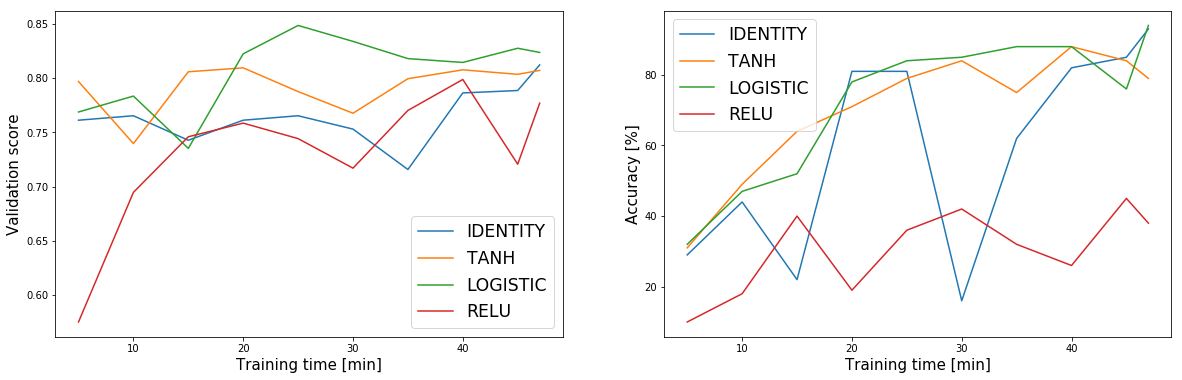

In [227]:
fig = plt.figure(figsize = (20,6))
plt.subplot(122)
plt.plot(t, acc_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(t, acc_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(t, acc_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(t, acc_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Training time [min]', fontsize = 15)
plt.ylabel('Accuracy [%]', fontsize = 15)

plt.subplot(121)
plt.plot(t, valscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(t, valscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(t, valscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(t, valscore_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Training time [min]', fontsize = 15)
plt.ylabel('Validation score', fontsize = 15)
plt.show()


In [218]:

times_dict = {}
for fcn in list_fcns:
    t = []
    for i in range(len(scores)):
        t.append(scores[i][fcn]['Time [s]'])
    times_dict[fcn] = t
acc_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Accuracy [%]'])
    acc_dict[fcn] = a

valscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Validation score'])
    valscore_dict[fcn] = a

trainscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Train score'])
    trainscore_dict[fcn] = a  
